In [20]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from neuraldb.dataset.base_reader import NeuralDatabaseDatasetReader
from neuraldb.dataset.generators.v0_4_database_reader import V4DatabaseSpecificReader
from matplotlib import pyplot as plt

In [32]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=fusion_sweep"
checkpoint_name = "metrics_test_distractors*"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

1800


In [33]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

def parse_file(param):
    bits = param.split("_")
    return {
        "source":bits[3],
        "num": int(bits[4]),
        "try": int(bits[5])
    }
experiments = []

for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file

    data.update(parse_file(os.path.basename(file)))

    data['dir'] = os.path.dirname(file)
    experiments.append(data)

In [34]:
for experiment in experiments:
    with open(experiment['file']) as f:
        results = json.load(f)

    experiment["EM"] = results['test']["EM"]

    for k,v in results['test']["raw"]["relation_type"].items():
        experiment["breakdown_{}".format(k)] = np.mean(v)

    for k,v in results['test']["raw"]["query_type"].items():
        experiment["query_{}".format(k)] = np.mean(v)

In [35]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("breakdown_"),results.columns)}
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
breakdown = pd.pivot_table(results, index=["model","context","source"],columns=["num"],aggfunc=cols)
breakdown

EM                                          \
                                 mean                                           
num                             1         10        50        100       1000    
model   context source                                                          
t5-base 100     distractors  0.780195  0.771564  0.754916  0.746961  0.739348   
                similar      0.780898  0.771813  0.751603  0.743527  0.717037   
        1000    distractors  0.774088  0.770903  0.761391  0.758496  0.753631   
                similar      0.774443  0.770721  0.758652  0.752612  0.745010   

                                                                               \
                                                                          std   
num                             2500      5000      7500      10000     1       
model   context source                                                          
t5-base 100     distractors  0.733774  0.729634  0.728015  0.728477  0.002656   
                similar      0.713762  0.702679  0.695559  0.689899  0.002640   
        1000    distractors  0.754095  0.756866  0.755376  0.753837  0.001431   
                similar      0.733317  0.731530  0.723968  0.723530  0.001042   

                             ... breakdown_spouse                      \
                             ...             mean       std             
num                          ...            10000     1         10      
model   context source       ...                                        
t5-base 100     distractors  ...         0.188924  0.036363  0.033048   
                similar      ...         0.217907  0.038068  0.034950   
        1000    distractors  ...         0.007500  0.050508  0.050508   
                similar      ...         0.100000  0.050508  0.050508   

                                                                               \
                                                                                
num                             50        100       1000      2500      5000    
model   context source                                                          
t5-base 100     distractors  0.032532  0.032499  0.038689  0.042849  0.043570   
                similar      0.030201  0.037106  0.045764  0.047846  0.053672   
        1000    distractors  0.050508  0.046291  0.024744  0.054398  0.017678   
                similar      0.043814  0.041033  0.052306  0.051349  0.094491   

                                                 
                                                 
num                             7500      10000  
model   context source                           
t5-base 100     distractors  0.054606  0.052384  
                similar      0.051448  0.053401  
        1000    distractors  0.029987  0.029987  
                similar      0.095030  0.123718  

[4 rows x 252 columns]

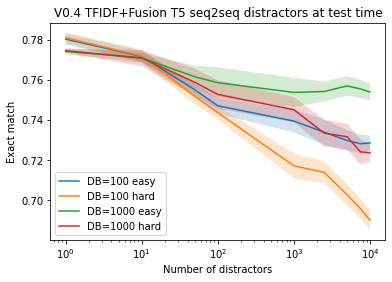

In [36]:
points = [1,10,50,100,1000,2500,5000,7500,10000]
labels =[]
for mod,ty in [("100","distractors"), ("100","similar"),("1000","distractors"),("1000","similar")]:
    means = [breakdown["EM"]["mean"].T["t5-base"].T[a][mod][ty] for a in points]
    stds = [breakdown["EM"]["std"].T["t5-base"].T[a][mod][ty] for a in points]

    upper = [mean+std for mean, std in zip(means,stds)]
    lower = [mean-std for mean, std in zip(means,stds)]

    plt.plot(points,means)
    plt.fill_between(points,lower,upper,alpha=0.2)
    labels.append("DB={} {}".format(mod,"easy" if ty =="distractors" else "hard"))

plt.title("V0.4 TFIDF+Fusion T5 seq2seq distractors at test time")
plt.legend(labels)
plt.ylabel("Exact match")
plt.xlabel("Number of distractors")
plt.xscale("log")
plt.show()